# 10th order

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

sampx = np.loadtxt('polydata_data_sampx.txt') 
sampy = np.loadtxt('polydata_data_sampy.txt')
polyx = np.loadtxt('polydata_data_polyx.txt') 
polyy = np.loadtxt('polydata_data_polyy.txt')

#10th orders
K = 10
def PHI(K,data):
    phi = []
    for i in range(0, K + 1):
        phi_inter = data ** i
        phi.append(phi_inter)
    phi = np.mat(phi)
    return phi
phisamp = PHI(K,sampx)

def plots(samp_x,samp_y,ploy_x,ploy_y,predict,label='name'):
    pl.plot(samp_x,samp_y,'bo',label='samples')
    pl.plot(ploy_x,predict,label=label)
    pl.plot(ploy_x,ploy_y,label='True function')
    pl.title(label)
    pl.legend() 
    pl.savefig(label+"-10th order.jpg")
    pl.close()
    return
def plots_BR(samp_x,samp_y,ploy_x,ploy_y,predict):
    pl.plot(samp_x,samp_y,'bo',label='samples')
    pl.plot(ploy_x,predict[0],label='function')
    pl.errorbar(ploy_x,ploy_y,np.sqrt(np.diag(predict[1])),label='True function')
    pl.title('BR-10th order')
    pl.legend()
    pl.savefig("BR-10th order.jpg")
    pl.show()

def MSE(trueoutput, learnedoutput):
    trueoutput = trueoutput.reshape(len(trueoutput),1)
    learnedoutput = learnedoutput.reshape(len(learnedoutput),1)
    return np.sum(np.square(trueoutput-learnedoutput))/np.size(trueoutput)

# Least square

In [7]:
#LS
def poly_LS(phi,y):
    return (phi * np.transpose(phi)).I * phi * np.transpose(np.mat(y))
ls = poly_LS(phisamp,sampy)
print('Estimated parameters: ',ls)
predict = np.transpose(PHI(K,polyx)) * ls
plots(sampx,sampy,polyx,polyy,predict,'LS')
MSE(polyy,predict)

Estimated parameters:  [[ -0.0993758 ]
 [  3.79351203]
 [  6.49122012]
 [-10.74477383]
 [ -5.52167701]
 [  8.63226351]
 [  0.6537136 ]
 [ -3.04579888]
 [  0.76354946]
 [  0.31028117]
 [ -0.17513791]]


7.9831065939212298

# Regularized LS

In [8]:
#RLS
def poly_RLS(phi,y,Labmda):
    return ((phi * np.transpose(phi) + Labmda * np.eye(np.shape(phi)[0])).I) * phi * np.transpose(np.mat(y))
rls = poly_RLS(phisamp,sampy,1)
print('Estimated parameters: ',rls)
predict = np.transpose(PHI(K,polyx)) * rls
plots(sampx,sampy,polyx,polyy,predict,'RLS')
MSE(polyy,predict)

Estimated parameters:  [[ 0.7595437 ]
 [ 0.65918517]
 [ 1.50632753]
 [-0.85990156]
 [-0.25391005]
 [-0.32677479]
 [-0.87939041]
 [ 0.02214144]
 [ 0.72637841]
 [-0.03939257]
 [-0.13283132]]


6.5480961652574656

# LASSO

In [9]:
#LASSO
def poly_LASSO(phi,y,Lambda):
    phiphiT = phi * np.transpose(phi)
    H = np.vstack(((np.hstack((phiphiT,-1 * phiphiT))),
              (np.hstack((-1 * phiphiT, phiphiT)))))    
    phiy = np.vstack((phi * np.transpose(np.mat(y)),-1 * phi * np.transpose(np.mat(y))))
    f = Lambda * np.ones(phiy.shape) - phiy
    G = np.eye(len(f))*-1
    h = np.zeros(len(f))
    sol = solvers.qp(matrix(H),matrix(f),matrix(G),matrix(h))
    x = sol['x']
    theta = x[:int(len(x)/2)]- x[int(len(x)/2):]
    return theta
lasso = poly_LASSO(phisamp,sampy,1)
print('Estimated parameters: ',lasso)
predict = np.dot(np.transpose(PHI(K,polyx)),lasso)
plots(sampx,sampy,polyx,polyy,predict,'LASSO')
MSE(polyy,predict)

     pcost       dcost       gap    pres   dres
 0: -1.0720e+03 -1.0201e+03  9e+01  1e+01  1e-04
 1: -1.0330e+03 -1.0447e+03  1e+01  1e-15  1e-14
 2: -1.0416e+03 -1.0428e+03  1e+00  6e-16  6e-15
 3: -1.0419e+03 -1.0422e+03  2e-01  4e-16  3e-15
 4: -1.0420e+03 -1.0421e+03  3e-02  5e-16  2e-15
 5: -1.0421e+03 -1.0421e+03  3e-04  6e-16  1e-15
Optimal solution found.
Estimated parameters:  [ 6.86e-01]
[ 5.97e-01]
[ 1.61e+00]
[-1.01e+00]
[-5.32e-05]
[-6.74e-06]
[-1.20e+00]
[-1.38e-01]
[ 8.38e-01]
[-1.65e-02]
[-1.45e-01]



6.1427147417704768

# RR

In [10]:
#RR
def poly_RR(phi,y):
    A = np.vstack(((np.hstack((-1 * np.transpose(phi),-1*np.eye(np.shape(np.transpose(phi))[0])))),
              (np.hstack((np.transpose(phi), -1*np.eye(np.shape(np.transpose(phi))[0]))))))  
    b = np.hstack((-y,y))
    f = np.hstack((np.zeros(np.shape(np.transpose(phi))[1]),np.ones(np.shape(np.transpose(phi))[0])))
    sol = solvers.lp(matrix(f),matrix(A),matrix(b))
    theta = np.array(sol['x'][:np.shape(np.transpose(phi))[1]])   
    return theta
rr = poly_RR(phisamp,sampy)
print('Estimated parameters: ',rr)
predict = np.dot(np.transpose(PHI(K,polyx)),rr)
plots(sampx,sampy,polyx,polyy,predict,'RR')
MSE(polyy,predict)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.5527e-15  3e+02  8e-01  1e-13  1e+00
 1:  3.7380e+01  3.7498e+01  5e+01  2e-01  3e-12  3e-01
 2:  5.2374e+01  5.2407e+01  1e+01  3e-02  3e-11  8e-02
 3:  5.6178e+01  5.6185e+01  2e+00  6e-03  4e-11  2e-02
 4:  5.6860e+01  5.6862e+01  4e-01  1e-03  2e-11  3e-03
 5:  5.6989e+01  5.6990e+01  9e-02  3e-04  2e-10  7e-04
 6:  5.7021e+01  5.7021e+01  9e-03  3e-05  7e-10  7e-05
 7:  5.7025e+01  5.7025e+01  1e-04  4e-07  2e-10  1e-06
 8:  5.7025e+01  5.7025e+01  1e-06  4e-09  8e-10  1e-08
Optimal solution found.
Estimated parameters:  [[ -0.77214105]
 [  3.02520284]
 [ 13.14885208]
 [ -7.57592858]
 [-19.78002485]
 [  5.64238716]
 [ 12.19446327]
 [ -2.16419898]
 [ -3.15723851]
 [  0.245386  ]
 [  0.29052242]]


1.2898574920191945

# Bayesian regression

Estimated parameters:  [[ 28.96310584]
 [ 29.67488157]
 [ 29.13261717]
 [ 27.73309625]
 [ 25.78787342]
 [ 23.53721699]
 [ 21.16228043]
 [ 18.79567463]
 [ 16.53060059]
 [ 14.42869067]
 [ 12.52669569]
 [ 10.84214445]
 [  9.37809247]
 [  8.1270672 ]
 [  7.07430795]
 [  6.2003905 ]
 [  5.48331806]
 [  4.90015297]
 [  4.42825618]
 [  4.04619495]
 [  3.73437311]
 [  3.47543201]
 [  3.25446511]
 [  3.05908401]
 [  2.87936886]
 [  2.7077319 ]
 [  2.53871874]
 [  2.36876838]
 [  2.19594948]
 [  2.01968749]
 [  1.84049422]
 [  1.65970928]
 [  1.4792602 ]
 [  1.30144642]
 [  1.12875031]
 [  0.96367711]
 [  0.8086243 ]
 [  0.66577974]
 [  0.53704725]
 [  0.4239974 ]
 [  0.32784079]
 [  0.24942089]
 [  0.18922288]
 [  0.14739535]
 [  0.12378115]
 [  0.11795439]
 [  0.12926021]
 [  0.15685474]
 [  0.19974267]
 [  0.25681043]
 [  0.3268534 ]
 [  0.40859598]
 [  0.50070413]
 [  0.60178992]
 [  0.7104089 ]
 [  0.82505089]
 [  0.94412567]
 [  1.06594523]
 [  1.18870474]
 [  1.31046455]
 [  1.42913582]
 

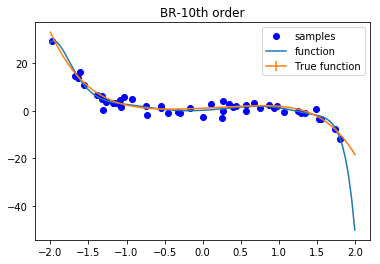

17.825211144177267

In [11]:
#Bayesian regression
def posterior(y,phi,alpha,sigma):
    thelta_cov = (1/alpha * np.eye(np.shape(phi)[0]) + 1/(sigma ** 2) * phi * np.transpose(phi)).I
    thelta_mean = 1/(sigma ** 2) * thelta_cov * phi * np.transpose(np.mat(y))
    return thelta_mean,thelta_cov
def poly_BR(x,thelta_mean,thelta_cov,K):
    thelta_mean_star = np.transpose(PHI(K,x)) * thelta_mean
    thelta_cov_star = np.transpose(PHI(K,x)) * thelta_cov * thelta_cov * PHI(K,x)
    return thelta_mean_star,thelta_cov_star
post = posterior(sampy, phisamp, 0.1, 0.1)
br = poly_BR(polyx,post[0],post[1],K)
print('Estimated parameters: ',br[0])
plots_BR(sampx,sampy,polyx,polyy,br)
MSE(polyy,br[0])

# Experiment with hyperparameters

In [12]:

Lambda = np.linspace(0.1,5,15)
mse_rls = []
for i in range(0,len(Lambda)):
    rls = poly_RLS(phisamp,sampy,Lambda[i])   
    predict = np.transpose(PHI(K,polyx)) * rls    
    mse_rls.append(MSE(polyy,predict))
Lambda[mse_rls.index(min(mse_rls))]

5.0

In [13]:
mse_lasso = []
for i in range(0,len(Lambda)):
    lasso = poly_LASSO(phisamp,sampy,Lambda[i])
    np.dot(np.transpose(PHI(K,polyx)),lasso)    
    mse_lasso.append(MSE(polyy,predict))
mse_lasso[mse_rls.index(min(mse_rls))]

     pcost       dcost       gap    pres   dres
 0: -1.0503e+03 -1.0399e+03  9e+01  1e+01  2e-04
 1: -1.0488e+03 -1.0591e+03  1e+01  1e+00  2e-05
 2: -1.0503e+03 -1.0533e+03  3e+00  2e-01  3e-06
 3: -1.0519e+03 -1.0522e+03  2e-01  7e-03  1e-07
 4: -1.0520e+03 -1.0521e+03  3e-02  7e-04  1e-08
 5: -1.0521e+03 -1.0521e+03  9e-04  2e-06  3e-11
 6: -1.0521e+03 -1.0521e+03  9e-06  2e-08  3e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0545e+03 -1.0280e+03  9e+01  1e+01  1e-04
 1: -1.0375e+03 -1.0489e+03  1e+01  3e-01  3e-06
 2: -1.0462e+03 -1.0473e+03  1e+00  3e-02  3e-07
 3: -1.0467e+03 -1.0469e+03  2e-01  3e-03  4e-08
 4: -1.0468e+03 -1.0468e+03  5e-03  5e-05  6e-10
 5: -1.0468e+03 -1.0468e+03  5e-05  5e-07  6e-12
 6: -1.0468e+03 -1.0468e+03  5e-07  5e-09  6e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0641e+03 -1.0214e+03  9e+01  1e+01  1e-04
 1: -1.0332e+03 -1.0456e+03  1e+01  2e-15  7e-15
 2: -1.0426e+03 -1.0442e

3.0432536006244981

In [14]:
mu = np.linspace(1,10,10)
ceta = np.linspace(1,5,5)
mse_br = np.zeros((10,5))
for i in range(0,len(mu)):
    for j in range(0,len(ceta)):
        post = posterior(sampy, phisamp, mu[i], ceta[j])
        br = poly_BR(polyx,post[0],post[1],K)   
        mse_br[i,j] = (MSE(polyy,br[0]))
re = np.where(mse_br == np.min(mse_br))
print(mu[re[0]])
print(np.square(ceta[re[1]]))        

[ 3.]
[ 25.]
